In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import uniform, norm, multivariate_normal
import statsmodels.tools.numdiff as nd
import numpy.matlib as npmat
from scipy.special import erfinv, erf
from scipy.optimize import minimize

a) We create 1000 samples of d_max with the joint PDFs of the uncertain variables.

We define our uncertain parameter sample space. In section 3, this would be equivalent to the notation of p(theta; M) and p(u; Mu) for our plausibility of each model and plausibility of inputs. 

In [3]:
K = 1000 # number of samples

L = 8 #m
I = 5e-3 #m4
E = np.exp(np.random.normal(np.log(200*10**6), 0.5, K))
Miou = np.array([4, 100]) # means for a and P respectively
Sigma_v = np.array([[1, -14], [-14 , 1225]]) # cov matrix for a and P
Pa = np.random.multivariate_normal(Miou, Sigma_v, K)
a = Pa[:, 0] #m
P = Pa[:, 1] #kN

We now define our function d_max

In [4]:
def d_max(a, P, E, L = 8, I = 5e-3):
    d = ((P * (a ** 2)) * ((L - a) ** 2)) / (3 * E * I * L)
    return d

We now estimate the mean and the c.o.v.

In [5]:
MC_gd = np.zeros((K,1)) #initialize variable
for k in range(0, K):
    MC_gd[k] = d_max(a[k], P[k], E[k]) #result of ith sample for g_x2

H_k = np.mean(MC_gd)
cov = (np.std(MC_gd) / np.mean(MC_gd)) * (1 / np.sqrt(K))

print(f'Estimate of integral: {round(H_k, 10)}\n'
      f'Estimate of cov of integral: {round(cov, 3)}')

Estimate of integral: 0.001044302
Estimate of cov of integral: 0.023


b) We now transform it to gaussian space. 

In [6]:
y = np.random.randn(3, K)

In [7]:
C = np.linalg.cholesky(Sigma_v)
samples_2 = (Miou[:, None] + C @ y[:2, :]).T
a = samples_2[:, 0]
P = samples_2[:, 1]

In [8]:
E = 200e6 * np.exp(y[2,:] * 0.5)

In [9]:
MC_gd_g = np.zeros((K,1)) #initialize variable
for k in range(0, K):
    MC_gd_g[k] = d_max(a[k], P[k], E[k]) #result of ith sample for g_x2

H_kg = np.mean(MC_gd_g)
covg = (np.std(MC_gd_g) / np.mean(MC_gd_g)) * (1 / np.sqrt(K))

print(f'Estimate of integral: {round(H_kg, 10)}\n'
      f'Estimate of cov of integral: {round(covg, 3)}')

Estimate of integral: 0.0011134673
Estimate of cov of integral: 0.022


For the graphs.

In [11]:
iters = np.arange(1, K+1, 1) 
MC_d = np.cumsum(MC_gd_g)/iters
MC_dcov = 1 / np.sqrt(iters)*np.sqrt(np.cumsum(MC_gd_g**2)/iters-MC_d**2)/MC_d

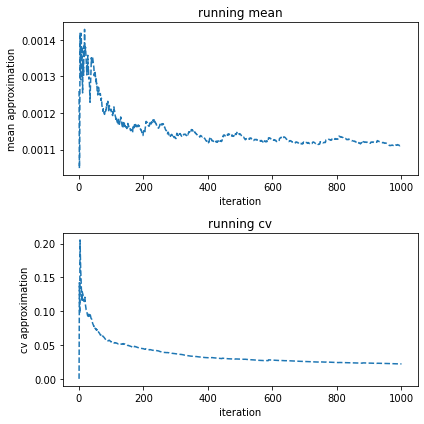

In [12]:
fig1 = plt.figure(tight_layout=True, figsize =(6,6)) 
ax1 = fig1.add_subplot(2, 1, 1)  
ax1.plot(iters, MC_d,'--');
ax1.set_xlabel('iteration');
ax1.set_ylabel('mean approximation');
ax1.set_title('running mean');

ax2 = fig1.add_subplot(2, 1, 2)  
ax2.plot(iters, MC_dcov, '--');
ax2.set_xlabel('iteration');
ax2.set_ylabel('cv approximation');
ax2.set_title('running cv');

c) What is the mode and the values of the parameters that maximize the integrand.

In [13]:
def transform(x):
# Code borrowed from Dr.T's code.
    C = np.linalg.cholesky(Sigma_v)
    samples_2 = (Miou[:, None] + C @ x[:2, :]).T
    a = samples_2[:, 0]
    P = samples_2[:, 1]
    E = (200e6)*np.exp(x[2, :] * 0.5)
    return (a, P, E)

In [14]:
def logintegrand(x):
    (a, P, E) = transform(x)
    h = d_max(a, P, E)
    f = np.log(h) + np.sum(norm.logpdf(x))
    return f

We use the function mminimize for the -log(h(y)p(y)). 

In [15]:
res=minimize(lambda x: -logintegrand(x.reshape(-1,1)), np.zeros(3))
print(np.exp(-res.fun))
z = [[res.x[0]], [res.x[1]]]
E = (200e6)*np.exp(res.x[2] * 0.5)
C = np.linalg.cholesky(Sigma_v)
samples_2 = (Miou[:, None] + C @ z).T
a = samples_2[:, 0]
P = samples_2[:, 1]
print('Gaussian space optimized parameters:\n'
     f'E = {res.x[2]}\na = {res.x[0]}\nP = {res.x[1]}')
print('Real space optimized parameters:\n'
     f'E = {E.round(0)}\na = {a[0].round(2)}\nP = {P[0].round(2)}\nd_max = {round(d_max(a, P, E)[0], 4)}')


8.095197462634086e-05
Gaussian space optimized parameters:
E = -0.5000004170734244
a = -0.10115152975625177
P = 0.289746392541327
Real space optimized parameters:
E = 155760124.0
a = 3.9
P = 110.71
d_max = 0.0015


d) With the info generated, we implementn IS. We try with different values of r (the scalar by which we multiply identity matrix I for the covariance matrix of q(x)). Our lowest value gives us 0.06 for c.o.v, but the mean

In [44]:
# Generate the samples
mu_IS = np.array([res.x[0], res.x[1], res.x[2]])

r = 1
sigma_IS = np.eye(3) * (r ** 2) 

q_samples = (mu_IS[:, None] + np.linalg.cholesky(sigma_IS) @ np.random.randn(3, K)) # generate random samples from q
q = multivariate_normal.pdf(q_samples.T, mu_IS, sigma_IS) #q(y)
p_y = multivariate_normal.pdf(q_samples.T, [0, 0, 0], np.eye(3)) #p(y)
w = p_y/q # weights of p(x)/q(x)

print(q_samples.shape)

C = np.linalg.cholesky(Sigma_v)
samples_2 = (Miou[:, None] + C @ q_samples[:2, :]).T
a = samples_2[:, 0]
P = samples_2[:, 1]
E = 200e6 * np.exp(q_samples[2, :] * 0.5)
print(E.shape)

MC_IS = np.zeros((K, 1))
# print(E.shape, a.shape)
for k in range(0, K):
    MC_IS[k] = d_max(a[k], P[k], E[k]) * w[k]

H_kg_IS = np.mean(MC_IS)
covg_IS = (np.std(MC_IS) / np.mean(MC_IS)) * (1 / np.sqrt(K))

print(f'Estimate of integral: {round(H_kg_IS, 10)}\n'
      f'Estimate of cov of integral: {round(covg_IS, 3)}')



(3, 1000)
(1000,)
Estimate of integral: 0.0010740231
Estimate of cov of integral: 0.006


In [45]:
iters = np.arange(1, K+1, 1) 
MC_dIS = np.cumsum(MC_IS)/iters
MC_IScov = 1 / np.sqrt(iters)*np.sqrt(np.cumsum(MC_IS**2)/iters-MC_dIS**2)/MC_dIS

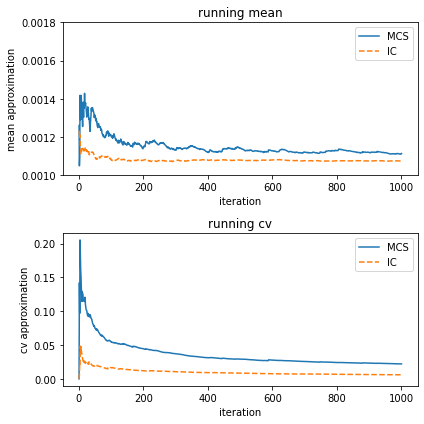

In [46]:
fig1 = plt.figure(tight_layout=True, figsize =(6,6)) 
ax1 = fig1.add_subplot(2, 1, 1)  
ax1.plot(iters, MC_d, label='MCS');
ax1.plot(iters, MC_dIS,'--', label='IC');
ax1.set_xlabel('iteration');
ax1.set_ylabel('mean approximation');
ax1.set_ylim(0.001, 0.0018)
ax1.legend()
ax1.set_title('running mean');
#
ax2 = fig1.add_subplot(2, 1, 2)  
ax2.plot(iters, MC_dcov, label='MCS')
ax2.plot(iters, MC_IScov,'--', label='IC');
ax2.set_xlabel('iteration');
ax2.set_ylabel('cv approximation');
ax2.legend()
ax2.set_title('running cv');

e) How many more samples do we need to obtaine same c.o.v obtained in d) using MCS.

In [48]:
np.var(MC_gd_g) / ((H_kg ** 2) * (0.006 ** 2))

np.float64(13584.80639663954)

f) To estimmate H, we need the hessian obtained from log of integrand. We then use it in our Taylor series appproximation.

In [19]:
H = nd.approx_hess(res.x,lambda x: -logintegrand(x.reshape(-1,1)))
H

array([[ 1.26646949e+00, -3.66403858e-02,  5.89260441e-07],
       [-3.66403858e-02,  1.08395285e+00,  2.05712984e-07],
       [ 5.89260441e-07,  2.05712984e-07,  1.00000000e+00]])

In [20]:
kopt = np.exp(-res.fun) #since fopt corresponds to -log(k(x*))
H_taylor = kopt*(2*np.pi)**(3/2)/np.sqrt(np.abs(np.linalg.det(H)))
H_taylor

np.float64(0.0010886973055558148)

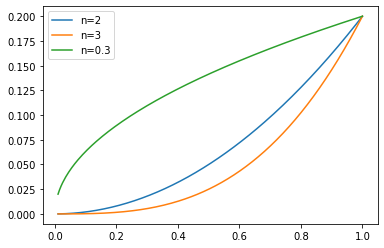

In [191]:
# fig, ax1 = plt.subplots()
# x = np.linspace(0.01, 1, 200)
# ax1.plot(x, 0.2 * (x/1) ** 2, label='n=2')
# ax1.plot(x, 0.2 * (x/1) ** 3, label='n=3')
# ax1.plot(x, 0.2 * (x/1) ** 0.5, label='n=0.3')
# ax1.legend()


/var/folders/m0/wg7jk5950_n3lf0_cdmws6z00000gn/T/ipykernel_14238/2527697860.py:44: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  dRdt = np.trapz(integrand, r) / (R**2 * X)


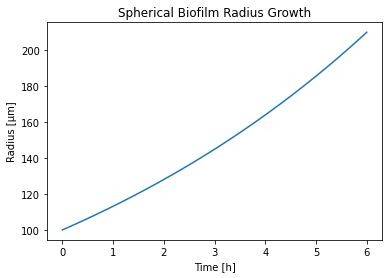

In [192]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters
# Ds   = 5e-10        # substrate diffusivity [m2/s]
# mu_m = 0.4/3600     # max specific growth rate [1/s]
# Ks   = 0.5          # half-sat constant [mg/L]
# Y    = 0.5          # yield [mgX/mgS]
# b    = 0.01/3600    # decay [1/s]
# X    = 100.0        # biomass conc [mgX/L]
# Sb   = 10.0         # bulk substrate [mg/L]
# R0   = 100e-6       # initial radius [m]
# t_end = 6*3600      # total time [s]
# dt   = 10.0         # time step [s]
# N    = 100          # spatial nodes

# # Spatial grid (we'll remesh as R changes)
# def solve_substrate(R):
#     r = np.linspace(0, R, N)
#     dr = r[1]-r[0]
#     S = np.ones(N)*Sb   # initial guess
#     # simple steady diffusion–reaction iteration
#     for _ in range(2000):
#         rX = mu_m*S/(Ks+S)*X - b*X
#         d2S = np.zeros(N)
#         d2S[1:-1] = (r[1:-1]**2*(S[2:]-2*S[1:-1]+S[:-2])/dr**2 +
#                       2*r[1:-1]*(S[2:]-S[:-2])/(2*dr)) / r[1:-1]**2
#         S_new = S + 1e-3*(Ds*d2S - rX/Y)
#         S_new[-1] = Sb
#         S_new[0] = S_new[1]   # symmetry
#         if np.max(abs(S_new-S))<1e-6: break
#         S = S_new
#     rX = mu_m*S/(Ks+S)*X - b*X
#     return r, S, rX

# # Time loop
# R = R0
# time, R_hist = [0], [R0]

# t = 0
# while t < t_end:
#     r, S, rX = solve_substrate(R)
#     integrand = rX * r**2
#     dRdt = np.trapz(integrand, r) / (R**2 * X)
#     R += dRdt * dt
#     t += dt
#     time.append(t)
#     R_hist.append(R)

# plt.plot(np.array(time)/3600, np.array(R_hist)*1e6)
# plt.xlabel("Time [h]")
# plt.ylabel("Radius [µm]")
# plt.title("Spherical Biofilm Radius Growth")
# plt.show()


/var/folders/m0/wg7jk5950_n3lf0_cdmws6z00000gn/T/ipykernel_14238/4216728821.py:53: DeprecationWarning: You are passing x=[0.00000000e+00 1.00502513e-07 2.01005025e-07 3.01507538e-07
 4.02010050e-07 5.02512563e-07 6.03015075e-07 7.03517588e-07
 8.04020101e-07 9.04522613e-07 1.00502513e-06 1.10552764e-06
 1.20603015e-06 1.30653266e-06 1.40703518e-06 1.50753769e-06
 1.60804020e-06 1.70854271e-06 1.80904523e-06 1.90954774e-06
 2.01005025e-06 2.11055276e-06 2.21105528e-06 2.31155779e-06
 2.41206030e-06 2.51256281e-06 2.61306533e-06 2.71356784e-06
 2.81407035e-06 2.91457286e-06 3.01507538e-06 3.11557789e-06
 3.21608040e-06 3.31658291e-06 3.41708543e-06 3.51758794e-06
 3.61809045e-06 3.71859296e-06 3.81909548e-06 3.91959799e-06
 4.02010050e-06 4.12060302e-06 4.22110553e-06 4.32160804e-06
 4.42211055e-06 4.52261307e-06 4.62311558e-06 4.72361809e-06
 4.82412060e-06 4.92462312e-06 5.02512563e-06 5.12562814e-06
 5.22613065e-06 5.32663317e-06 5.42713568e-06 5.52763819e-06
 5.62814070e-06 5.7286432

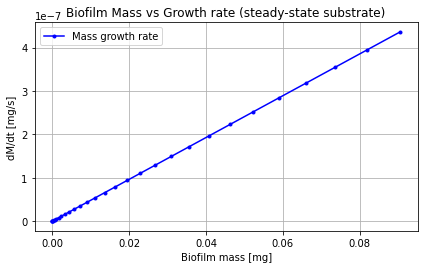

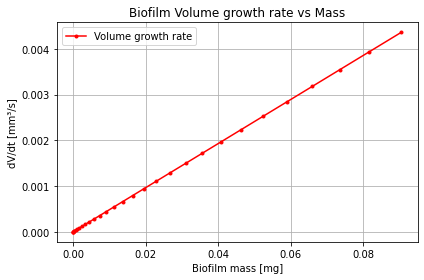

In [197]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.integrate import simpson

# # -------------------------------
# # Parameters
# # -------------------------------
# Ds   = 1e-9        # substrate diffusivity [m2/s]
# mu_m = 0.5/86400   # max growth rate [1/s]  (0.5 per day)
# Ks   = 10.0        # half-saturation [mg/L]
# X    = 100.0       # biomass density [kg/m3]
# Y    = 0.5         # yield [kgX/kgS] (not directly used here)
# Sb   = 50.0        # bulk substrate [mg/L]

# # Radii to test
# R_list = np.linspace(20e-6, 600e-6, 30)  # 20 µm to 600 µm
# N = 200  # radial grid points

# M_list = []
# dMdt_list = []
# dVdt_list = []

# # -------------------------------
# # Steady-state solver for S(r)
# # -------------------------------
# def steady_substrate(R):
#     r = np.linspace(0, R, N)
#     dr = r[1] - r[0]
#     # initial guess
#     S = np.ones_like(r) * Sb
#     for _ in range(2000):
#         rX = mu_m * S/(Ks + S) * X     # [kg/m3/s]
#         reaction = rX / (Y * 1000)     # convert to mg/L/s (approx)
#         d2S = np.zeros_like(S)
#         for i in range(1, N-1):
#             d2S[i] = (1/r[i]**2)*((r[i+1]**2*(S[i+1]-S[i]) - r[i-1]**2*(S[i]-S[i-1]))/(dr**2))
#         S_new = S + 1e-3*(Ds*d2S - reaction)
#         S_new[-1] = Sb
#         S_new[0] = S_new[1]
#         if np.max(np.abs(S_new - S)) < 1e-6:
#             S = S_new
#             break
#         S = S_new
#     rX = mu_m * S/(Ks + S) * X
#     return r, S, rX

# # -------------------------------
# # Loop over radius
# # -------------------------------
# for R in R_list:
#     r, S, rX = steady_substrate(R)
#     # integrate growth rate
#     dMdt = 4*np.pi * simpson(rX * r**2, r)  # [kg/s]
#     M = (4/3)*np.pi*R**3 * X                # [kg]
#     dVdt = dMdt / X                         # [m3/s]
#     M_list.append(M)
#     dMdt_list.append(dMdt)
#     dVdt_list.append(dVdt)

# # -------------------------------
# # Plot Mass vs Growth rate (mass & volume)
# # -------------------------------
# plt.figure(figsize=(6,4))
# plt.plot(np.array(M_list)*1e6, np.array(dMdt_list)*1e6, 'b.-', label='Mass growth rate')
# plt.xlabel('Biofilm mass [mg]')
# plt.ylabel('dM/dt [mg/s]')
# plt.title('Biofilm Mass vs Growth rate (steady-state substrate)')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(6,4))
# plt.plot(np.array(M_list)*1e6, np.array(dVdt_list)*1e12, 'r.-', label='Volume growth rate')
# plt.xlabel('Biofilm mass [mg]')
# plt.ylabel('dV/dt [mm³/s]')
# plt.title('Biofilm Volume growth rate vs Mass')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()
